In this notebook we reproduce one of the classifiers demonstrated in the paper [In Silico Prediction of Cytochrome P450-Drug Interaction: QSARs for CYP3A4 and CYP2C9](https://www.mdpi.com/1422-0067/17/6/914). Then we will use the same data to explore other methods such as SVM or neural networks.

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf


PATH_DATA = "../datasets/CYP/"

Load training data, separate labels from features and select the features used in the paper for the KNeighbors Classifiers

In [2]:
train_data = pd.read_csv(os.path.join(PATH_DATA, "CYP2C9_dataset_training.csv"), decimal=",")
train_labels = (train_data["Class"] == "Active").values.astype(int)
train_data = train_data.drop(columns="Class")
train_data = train_data.astype({"SMILES": object, "Sp": float, "nBM": int, "ARR": float, "nPyrimidines": int, "HyWi_B(m)": float, "GATS2i": float, "Eta_betaP_A": float, "nRNR2": int, "F01[C-N]": int, "MLOGP": float})
train_data_orig = train_data.copy()
# train_data will contain all the features, while train_data_knn will contain the ones used by the knn in the paper
train_data = train_data.drop(columns="SMILES")
train_data_knn = train_data_orig.iloc[:,[5, 6, 7, 8, 9, 10]]

Load testing data, separate labels from features and select the features used in the paper for the KNeighbors Classifiers

In [3]:
test_data = pd.read_csv(os.path.join(PATH_DATA, "CYP2C9_dataset_testing.csv"), decimal=",")
test_labels = (test_data["Class"] == "Active").values.astype(int)
test_data = test_data.drop(columns="Class")
test_data = test_data.astype({"SMILES": object, "Sp": float, "nBM": int, "ARR": float, "nPyrimidines": int, "HyWi_B(m)": float, "GATS2i": float, "Eta_betaP_A": float, "nRNR2": int, "F01[C-N]": int, "MLOGP": float})
test_data_orig = test_data.copy()
test_data = test_data.drop(columns="SMILES")
test_data_knn = test_data_orig.iloc[:,[5, 6, 7, 8, 9, 10]]

Assign appropiate data types to the features

Test a KNeighbors classifier:

In [4]:
nbrs = KNeighborsClassifier(n_neighbors=14, algorithm='ball_tree')
nbrs.fit(train_data_knn, train_labels)
predicted = nbrs.predict(test_data_knn)

In [5]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    ner = (Sn+Sp)/2
    print("NER:", ner, "Sensitivity:", Sn, "Specificity:", Sp)
    return ner, Sn, Sp

In [6]:
print_metrics(predicted, test_labels)

NER: 0.7336992681304059 Sensitivity: 0.6111111111111112 Specificity: 0.8562874251497006


(0.7336992681304059, 0.6111111111111112, 0.8562874251497006)

Try a SVM with all features:

In [7]:
svm = SVC()
svm.fit(train_data, train_labels)
predicted = svm.predict(test_data)
print_metrics(predicted, test_labels)

NER: 0.7163575878545938 Sensitivity: 0.5377777777777778 Specificity: 0.8949373979314099


(0.7163575878545938, 0.5377777777777778, 0.8949373979314099)

Try a SVM with the KNeighbors features:

In [8]:
svm = SVC()
svm.fit(train_data_knn, train_labels)
predicted = svm.predict(test_data_knn)
print_metrics(predicted, test_labels)

NER: 0.7198363878303998 Sensitivity: 0.5588888888888889 Specificity: 0.8807838867719108


(0.7198363878303998, 0.5588888888888889, 0.8807838867719108)

We next do a quick sweep over several values of the regularization parameter for the SVM with all the features

Scores using C=0.01
NER: 0.5078113470029638 Sensitivity: 0.01888888888888889 Specificity: 0.9967338051170387
Scores using C=0.016237767391887217
NER: 0.5832253674469243 Sensitivity: 0.21 Specificity: 0.9564507348938487
Scores using C=0.026366508987303583
NER: 0.6320882477469303 Sensitivity: 0.3322222222222222 Specificity: 0.9319542732716385
Scores using C=0.04281332398719394
NER: 0.6544671263533539 Sensitivity: 0.39222222222222225 Specificity: 0.9167120304844856
Scores using C=0.06951927961775606
NER: 0.6647952579689107 Sensitivity: 0.4177777777777778 Specificity: 0.9118127381600436
Scores using C=0.11288378916846889
NER: 0.6792508921550837 Sensitivity: 0.4477777777777778 Specificity: 0.9107240065323897
Scores using C=0.18329807108324356
NER: 0.684817637452368 Sensitivity: 0.46 Specificity: 0.909635274904736
Scores using C=0.29763514416313175
NER: 0.6890458476985424 Sensitivity: 0.47444444444444445 Specificity: 0.9036472509526402
Scores using C=0.4832930238571752
NER: 0.702390370773604

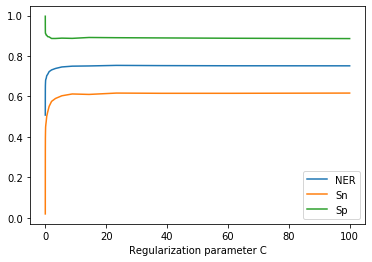

Best C value is  23.357214690901213


In [9]:
C_values = np.geomspace(0.01, 100, num=20)
ner_vals = []
Sn_vals = []
Sp_vals = []
for c in C_values:
    svm = SVC(C=c)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(test_data)
    print(f"Scores using C={c}")
    ner, sn, sp = print_metrics(predicted, test_labels)
    ner_vals.append(ner)
    Sn_vals.append(sn)
    Sp_vals.append(sp)
plt.plot(C_values, ner_vals, label="NER")
plt.plot(C_values, Sn_vals, label="Sn")
plt.plot(C_values, Sp_vals, label="Sp")
plt.legend()
plt.xlabel("Regularization parameter C")
plt.show()
print("Best C value is ", C_values[np.argmax(ner_vals)])

We do the same with the knn features

Scores using C=0.01
NER: 0.5 Sensitivity: 0.0 Specificity: 1.0
Scores using C=0.016237767391887217
NER: 0.5 Sensitivity: 0.0 Specificity: 1.0
Scores using C=0.026366508987303583
NER: 0.5 Sensitivity: 0.0 Specificity: 1.0
Scores using C=0.04281332398719394
NER: 0.5234787999758059 Sensitivity: 0.06111111111111111 Specificity: 0.9858464888405009
Scores using C=0.06951927961775606
NER: 0.6057161434706344 Sensitivity: 0.2811111111111111 Specificity: 0.9303211758301578
Scores using C=0.11288378916846889
NER: 0.6367452972842194 Sensitivity: 0.3622222222222222 Specificity: 0.9112683723462166
Scores using C=0.18329807108324356
NER: 0.6696237827375552 Sensitivity: 0.43777777777777777 Specificity: 0.9014697876973327
Scores using C=0.29763514416313175
NER: 0.6874910784491624 Sensitivity: 0.4822222222222222 Specificity: 0.8927599346761024
Scores using C=0.4832930238571752
NER: 0.7086581382689168 Sensitivity: 0.53 Specificity: 0.8873162765378334
Scores using C=0.7847599703514611
NER: 0.7153919433859

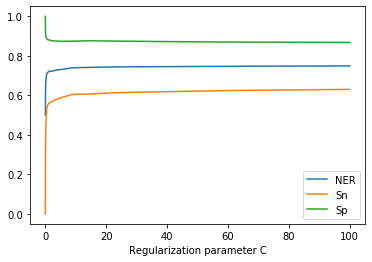

Best C value is  100.0


In [10]:
C_values = np.geomspace(0.01, 100, num=20)
ner_vals = []
Sn_vals = []
Sp_vals = []
for c in C_values:
    svm = SVC(C=c)
    svm.fit(train_data_knn, train_labels)
    predicted = svm.predict(test_data_knn)
    print(f"Scores using C={c}")
    ner, sn, sp = print_metrics(predicted, test_labels)
    ner_vals.append(ner)
    Sn_vals.append(sn)
    Sp_vals.append(sp)
plt.plot(C_values, ner_vals, label="NER")
plt.plot(C_values, Sn_vals, label="Sn")
plt.plot(C_values, Sp_vals, label="Sp")
plt.legend()
plt.xlabel("Regularization parameter C")
plt.show()
print("Best C value is ", C_values[np.argmax(ner_vals)])

Using all the features seems to work slightly better (although not much), so we know test the kernel

In [11]:
kernels = ["rbf", "poly", "linear", "sigmoid"]
for k in kernels:
    svm = SVC(kernel=k, C=23)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(test_data)
    print(f"Scores using {k} kernel")
    ner, sn, sp = print_metrics(predicted, test_labels)

Scores using rbf kernel
NER: 0.7530802032299038 Sensitivity: 0.6166666666666667 Specificity: 0.889493739793141
Scores using poly kernel
NER: 0.7399742938365693 Sensitivity: 0.5855555555555556 Specificity: 0.894393032117583
Scores using linear kernel
NER: 0.7247916288634851 Sensitivity: 0.5644444444444444 Specificity: 0.8851388132825259
Scores using sigmoid kernel
NER: 0.6365444867840078 Sensitivity: 0.5044444444444445 Specificity: 0.7686445291235711


We now will try to use a simple neural network to improve the predictions

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(6, activation="softmax"),
    tf.keras.layers.Dense(2, activation="softmax")
])
model.summary()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_function, metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(train_data, train_labels, epochs=5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 14        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
200/200 [==============================] - 1s 4ms/step - loss: 0.6946 - categorical_accuracy: 0.4576
Epoch 2/5
200/200 [==============================] - 1s 3ms/step - loss: 0.6932 - categorical_accuracy: 0.4756
Epoch 3/5
200/200 [==============================] - 1s 3ms/step - loss: 0.6932 - categorical_accuracy: 0.4968
Epoch 4/5
200/200 [==============================] - 

In [17]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
print_metrics(predictions, test_labels)

86/86 [==============================] - 0s 2ms/step - loss: 0.6932 - categorical_accuracy: 0.2729
NER: 0.43927206193673257 Sensitivity: 0.6455555555555555 Specificity: 0.23298856831790962


(0.43927206193673257, 0.6455555555555555, 0.23298856831790962)